In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

### Scrape movie data

In [2]:
urls=[f'https://www.the-numbers.com/movie/budgets/all/{i}' for i in range(101,60001,100)]

In [3]:
df=pd.DataFrame()
for url in urls:
    html=requests.get(url,headers).content
    time.sleep(2)
    data=pd.read_html(html)[0]

    if len(data)==0:
        break

    df=pd.concat([df,data],ignore_index=True)

    print(url, end='\r')

In [4]:
df.to_csv('movies.csv',index=False)

In [68]:
df=pd.read_csv('movies.csv')

In [69]:
df=df.drop(columns='Unnamed: 0')

In [70]:
df

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,"May 28, 2010",Prince of Persia: Sands of Time,"$200,000,000","$90,759,676","$336,359,676"
1,"Oct 18, 2023",Killers of the Flower Moon,"$200,000,000","$68,035,488","$156,432,918"
2,"Jun 5, 2019",Dark Phoenix,"$200,000,000","$65,845,974","$246,356,895"
3,"Nov 22, 2023",Wish,"$200,000,000","$63,973,821","$237,954,897"
4,"Feb 28, 2020",Onward,"$200,000,000","$61,555,145","$133,357,601"
...,...,...,...,...,...
6516,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
6517,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
6518,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
6519,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


In [71]:
df['Release Date']=pd.to_datetime(df['Release Date'], format="%b %d, %Y",errors='coerce')
df['Release Date']=df['Release Date'].dt.to_period('M')
df['Release Date']=df['Release Date'].astype(str)

In [72]:
for col in ['Production Budget','Domestic Gross','Worldwide Gross']:
    df[col]=df[col].str.replace('$','').str.replace(',','').apply(pd.to_numeric)

In [73]:
df

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,2010-05,Prince of Persia: Sands of Time,200000000,90759676,336359676
1,2023-10,Killers of the Flower Moon,200000000,68035488,156432918
2,2019-06,Dark Phoenix,200000000,65845974,246356895
3,2023-11,Wish,200000000,63973821,237954897
4,2020-02,Onward,200000000,61555145,133357601
...,...,...,...,...,...
6516,1999-04,Following,6000,48482,240495
6517,2005-07,Return to the Land of Wonders,5000,1338,1338
6518,2015-09,A Plague So Pleasant,1400,0,0
6519,2005-08,My Date With Drew,1100,181041,181041


### Scrape CPI data

In [74]:
cpi_df=pd.read_html('https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/')[0]
cpi_df.columns=cpi_df.iloc[1]
cpi_df=cpi_df.iloc[2:,:]

In [75]:
cpi_df=cpi_df.drop(columns=['Avg','Dec-Dec','Avg-Avg'])

In [76]:
df_melted = cpi_df.melt(id_vars='Year', var_name='Month', value_name='CPI')

month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
    'May': '05', 'June': '06', 'July': '07', 'Aug': '08',
    'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
df_melted['Month'] = df_melted['Month'].map(month_map)

df_melted['Date'] = df_melted['Year'].astype(str) + '-' + df_melted['Month']

df_melted=df_melted.drop(columns=['Year','Month'])

In [78]:
df=df.merge(df_melted,left_on='Release Date',right_on='Date').drop(columns='Date')

In [79]:
df

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross,CPI
0,2010-05,Prince of Persia: Sands of Time,200000000,90759676,336359676,218.178
1,2023-10,Killers of the Flower Moon,200000000,68035488,156432918,307.671
2,2019-06,Dark Phoenix,200000000,65845974,246356895,256.143
3,2023-11,Wish,200000000,63973821,237954897,307.051
4,2020-02,Onward,200000000,61555145,133357601,258.678
...,...,...,...,...,...,...
6366,1999-04,Following,6000,48482,240495,166.2
6367,2005-07,Return to the Land of Wonders,5000,1338,1338,195.4
6368,2015-09,A Plague So Pleasant,1400,0,0,237.945
6369,2005-08,My Date With Drew,1100,181041,181041,196.4


### Finalizing

In [93]:
df['CPI']=df['CPI'].apply(pd.to_numeric,errors='coerce')

latest_cpi=df[df['Release Date']=='2025-03']['CPI'].iloc[0]


df['CPI']=df['CPI']/latest_cpi

In [97]:
for col in ['Production Budget','Domestic Gross','Worldwide Gross']:
    df[col]=df[col]/df['CPI']

In [ ]:
df['Gross Profit Margin']=df['Worldwide Gross']/df['Production Budget']

In [ ]:
df=df.dropna(how='any')

df=df.drop(columns='CPI')

df=df.sort_values('Release Date')

In [11]:
df.to_csv('highest grossing movies.csv',index=False)

### EDA

In [2]:
df=pd.read_csv("highest grossing movies.csv")

In [3]:
df

,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross,Gross Profit Margin
0,1915-02,The Birth of a Nation,3.517789e+06,3.197990e+08,3.517789e+08,100.000000
1,1916-09,Intolerance,1.111826e+07,0.000000e+00,0.000000e+00,0.000000
2,1916-12,"20,000 Leagues Under the Sea",5.513776e+06,2.205510e+08,2.205510e+08,40.000000
3,1920-09,Over the Hill to the Poorhouse,1.598995e+06,4.796985e+07,4.796985e+07,30.000000
4,1925-11,The Big Parade,4.352820e+06,1.954327e+08,3.908654e+08,89.795918
...,...,...,...,...,...,...
6353,2025-03,A Working Man,4.000000e+07,3.046119e+07,5.667777e+07,1.416944
6354,2025-03,Opus,1.000000e+07,1.830654e+06,2.084215e+06,0.208422
6355,2025-03,Black Bag,6.000000e+07,2.098000e+07,3.557095e+07,0.592849
6356,2025-03,Death of a Unicorn,1.500000e+07,1.078327e+07,1.110935e+07,0.740623


In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
filtered_df=df[df['Worldwide Gross']>=10e6]
years=filtered_df['Release Date'].apply(lambda x:x.split('-')[0]).apply(pd.to_numeric)

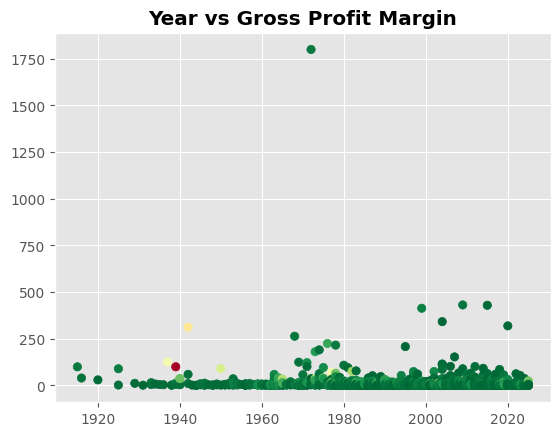

In [8]:
plt.scatter(x=years,y=filtered_df['Gross Profit Margin'],alpha=1,c=filtered_df['Worldwide Gross'],cmap='RdYlGn_r')
plt.title('Year vs Gross Profit Margin',fontweight='bold')
plt.show()

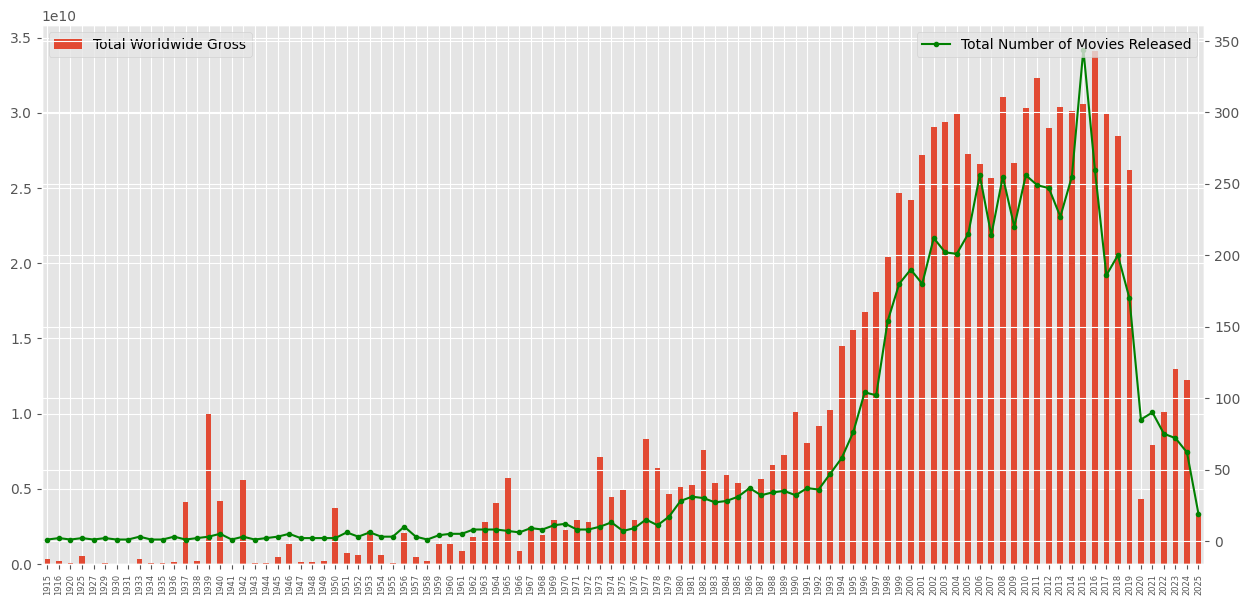

In [11]:
grouped=df.groupby(df['Release Date'].apply(lambda x:x.split('-')[0])).agg({'Movie':'count','Worldwide Gross':'sum'}).reset_index()

fig,ax=plt.subplots(figsize=(15,7))
ax2=ax.twinx()
grouped.plot.bar(ax=ax,y='Worldwide Gross',label='Total Worldwide Gross')
grouped.plot(ax=ax2,y='Movie',color='green',label='Total Number of Movies Released',marker='.')
ax2.legend(loc='upper right')
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped['Release Date'], rotation=90,size=6)
plt.show()

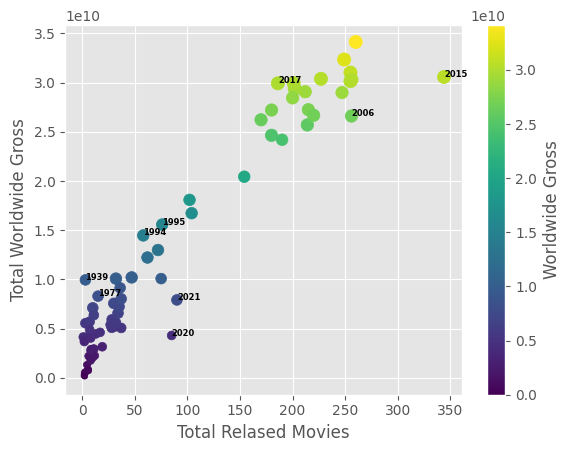

In [31]:
import numpy as np

x = grouped['Movie'].values
y = grouped['Worldwide Gross'].values

slope, intercept = np.polyfit(x, y, 1)
preds = slope * x + intercept
residuals = np.abs(y - preds)

threshold = residuals.std() * 2.5


grouped.plot.scatter(x='Movie',y='Worldwide Gross', s=pd.qcut(grouped['Worldwide Gross'],q=10,labels=False)*10,c='Worldwide Gross')
for i in range(len(grouped)):
    if residuals[i] > threshold:
        plt.text(grouped['Movie'].iloc[i],grouped['Worldwide Gross'].iloc[i],grouped['Release Date'].iloc[i],size=6,fontweight='bold')

plt.xlabel('Total Relased Movies')
plt.ylabel('Total Worldwide Gross')

plt.show()